In [ ]:
#!pip install neuralforecast

# **LIBRARY PREPARATION**

In [ ]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP, FEDformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset

from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from scipy.signal import savgol_filter

# **NVL DATA PREPARATION**

In [ ]:
# Read Data
df = pd.read_csv('NVL Historical Data 1_6 Fed.csv')

In [ ]:
# Add ID constraint
df1 = df
df1['unique_id'] = 'NVL'

# Reorder columns
df1 = df1[['unique_id', 'Date', 'Price']]

# Rename
df1.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)
df1

,unique_id,ds,y
0,NVL,2018-01-02,27815.0
1,NVL,2018-01-03,28410.0
2,NVL,2018-01-04,28707.0
3,NVL,2018-01-05,28962.0
4,NVL,2018-01-06,28473.5
...,...,...,...
2338,NVL,2024-05-28,14500.0
2339,NVL,2024-05-29,14150.0
2340,NVL,2024-05-30,14150.0
2341,NVL,2024-05-31,14450.0


In [ ]:
# Change Data Type
df1['ds'] = pd.to_datetime(df1['ds'])
df1['y'] = df1['y'].astype(float)

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  2343 non-null   object        
 1   ds         2343 non-null   datetime64[ns]
 2   y          2343 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 55.0+ KB


# **TRAIN-TEST SPLIT**

In [ ]:
# Sizing
size = int(len(df1))

# 8 : 2 Ratio
train_data = df1[:int(0.8 *size)]
test_data = df1[int(0.8 * size):]
train_len = len(train_data)
test_len = len(test_data)
print("Training lenght:" , train_len)
print("Test lenght:" , test_len)

Training lenght: 1874
Test lenght: 469


In [ ]:
# Train_data MAX Value
train_data.max()

unique_id                    NVL
ds           2023-02-18 00:00:00
y                        92366.0
dtype: object

# **TRAINING PROCESSS**

In [ ]:
# Model Configuration
model = FEDformer(
    h=test_len + 90,
    input_size = 100,  # 100 Days of input size
    modes=64,  # Reduced modes for less complexity
    hidden_size=128,  # Increased hidden size
    n_head=8,  # Must be set to 8
    loss=MAE(),
    scaler_type='standard',  # Change the scaler type
    learning_rate=1e-3,  # Fine-tune the learning rate
    max_steps=100,  # Increase the number of training steps
    batch_size=32,  # Adjust batch size
    windows_batch_size=256,  # Adjust window batch size
)

nf = NeuralForecast(
    models=[model],
    freq='D',
)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
# Training
nf.fit(df=train_data, static_df=None, verbose=True)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 251 K  | train
7 | decoder       | Decoder       | 403 K  | train
--------------------------------------------------------
655 K     Trainable params
0         Non-trainable 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


# **PREDICTION**


In [ ]:
forecasts = nf.predict()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
# Reset Index
train = train_data['y']
test = test_data['y']

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

predict = forecasts['FEDformer']
predict.reset_index(drop=True, inplace=True)

In [ ]:
predict_test = predict[0:test_len]
predict_future = predict[test_len:]

In [ ]:
# Order predict_future
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]

In [ ]:
# Print Predicted Data
print("\nPredicted Data for the next 30 days:")
print(predict_future_30)

print("\nPredicted Data for the next 60 days:")
print(predict_future_60)

print("\nPredicted Data for the next 90 days:")
print(predict_future_90)


Predicted Data for the next 30 days:
469    27489.523438
470    29521.125000
471    27468.103516
472    30018.320312
473    28480.898438
474    27471.916016
475    29330.328125
476    26581.152344
477    28230.218750
478    27373.250000
479    27874.523438
480    28974.425781
481    26516.279297
482    28271.816406
483    26837.281250
484    29067.359375
485    29163.105469
486    29837.595703
487    26955.029297
488    27320.332031
489    29307.902344
490    26920.777344
491    28375.333984
492    27718.179688
493    27995.195312
494    28377.195312
495    26225.421875
496    27609.839844
497    26290.437500
498    27555.363281
Name: FEDformer, dtype: float32

Predicted Data for the next 60 days:
499    28676.125000
500    26346.251953
501    27550.320312
502    26895.386719
503    27424.529297
504    28606.750000
505    26463.130859
506    26641.015625
507    26794.501953
508    27669.382812
509    26836.513672
510    28383.589844
511    27035.626953
512    27688.314453
513    28022

# **EVALUATION**

In [ ]:
mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
mse = mean_squared_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Square Error (MSE):", mse)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 11449.237687122424
Mean Absolute Percentage Error (MAPE): 0.7749970854430546
Mean Square Error (MSE): 138562224.45467034
Root Mean Square Error (RMSE): 11771.245662828991


# **VISUALIZATION**

In [ ]:
# prompt: adding first_value to the last of test
first_value = predict_test.iloc[0]
train_draw = pd.concat([train, pd.Series([first_value])], ignore_index=True)

**Overall Visualization**

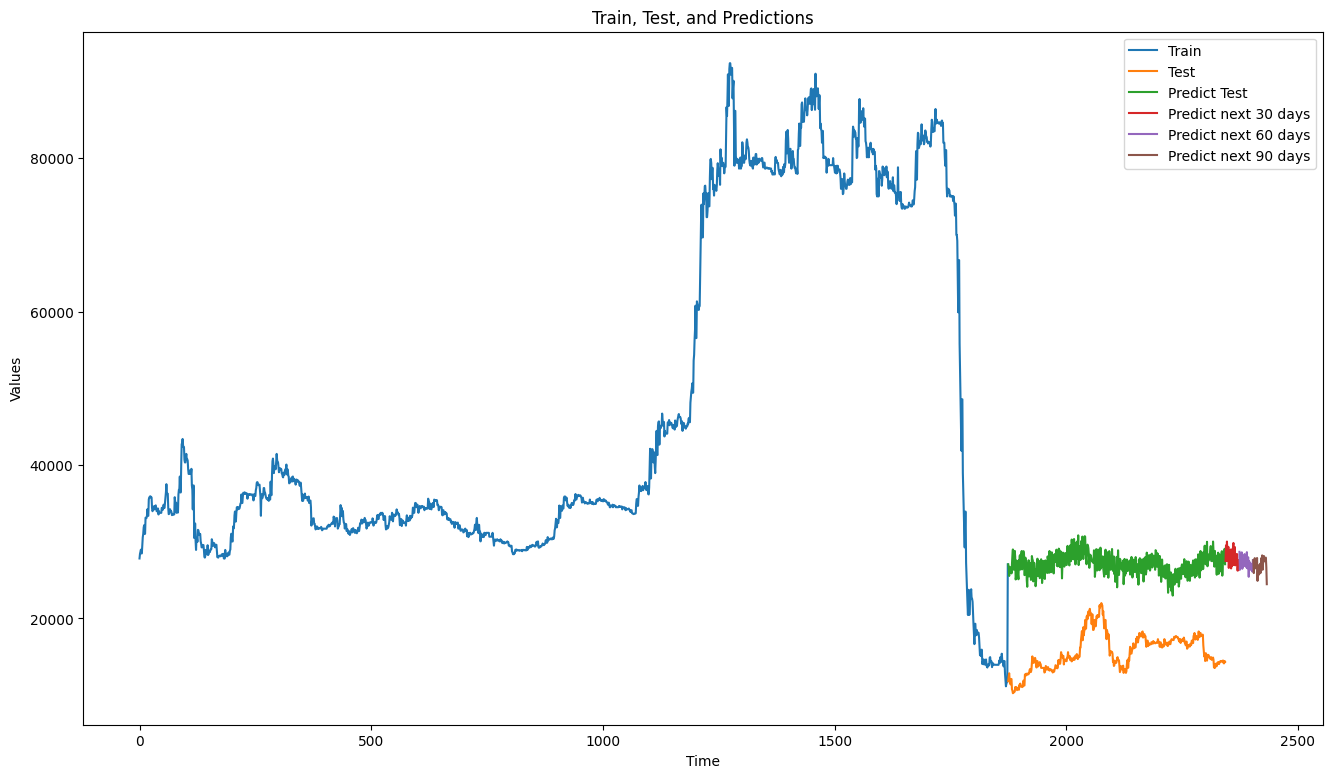

In [ ]:
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)

predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))

predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Train, Test, and Predictions')
plt.show()

# **---------------------------------------**

# **POLYNOMINAL SMOOTHING**

In [ ]:
predict_smoothed = savgol_filter(predict, window_length=31, polyorder=3)

# **RE - PREDICTION**


In [ ]:
predict_test = predict_smoothed[0:test_len]
predict_future = predict_smoothed[test_len:]

In [ ]:
# Order predict_future
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]

In [ ]:
# Print Predicted Data
print("\nPredicted Data for the next 30 days:")
print(predict_future_30)

print("\nPredicted Data for the next 60 days:")
print(predict_future_60)

print("\nPredicted Data for the next 90 days:")
print(predict_future_90)


Predicted Data for the next 30 days:
[28058.611 27970.182 27985.871 28133.512 28178.504 28148.857 28159.818
 28192.54  28284.768 28192.877 28143.125 28169.607 28131.08  28169.725
 28173.477 28028.898 28000.182 28004.684 27939.719 27975.947 27905.557
 27889.371 27946.355 27850.762 27781.58  27706.887 27580.078 27585.564
 27437.432 27358.299]

Predicted Data for the next 60 days:
[27269.963 27199.469 27259.402 27314.117 27243.332 27296.469 27345.295
 27319.602 27340.814 27341.498 27396.434 27447.662 27382.094 27414.68
 27300.266 27249.828 27341.562 27244.133 27187.559 27164.557 27124.598
 27189.055 27132.996 27033.312 27067.871 27028.723 27002.932 27007.752
 26951.938 26945.93 ]

Predicted Data for the next 90 days:
[26903.24  26854.479 26822.889 26756.48  26706.209 26777.256 26680.25
 26660.39  26607.85  26626.258 26649.945 26629.537 26637.95  26720.059
 26835.965 26949.824 27061.645 27166.865 27260.914 27339.23  27397.246
 27430.396 27434.115 27403.836 27334.994 27223.023 27063.357 26

# **RE - EVALUATION**

In [ ]:
mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
mse = mean_squared_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Square Error (MSE):", mse)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 11452.203276308192
Mean Absolute Percentage Error (MAPE): 0.7752221235388663
Mean Square Error (MSE): 137647688.71154433
Root Mean Square Error (RMSE): 11732.335177258803


# **RE - VISUALIZATION**

In [ ]:
# Assuming predict_test is a NumPy array
first_value = pd.Series(predict_test.reshape(-1))  # Convert to pandas Series

# Concatenate train and first_value as Series in a new DataFrame
train_draw = pd.concat([train, first_value], ignore_index=True)

**Overall Visualization**

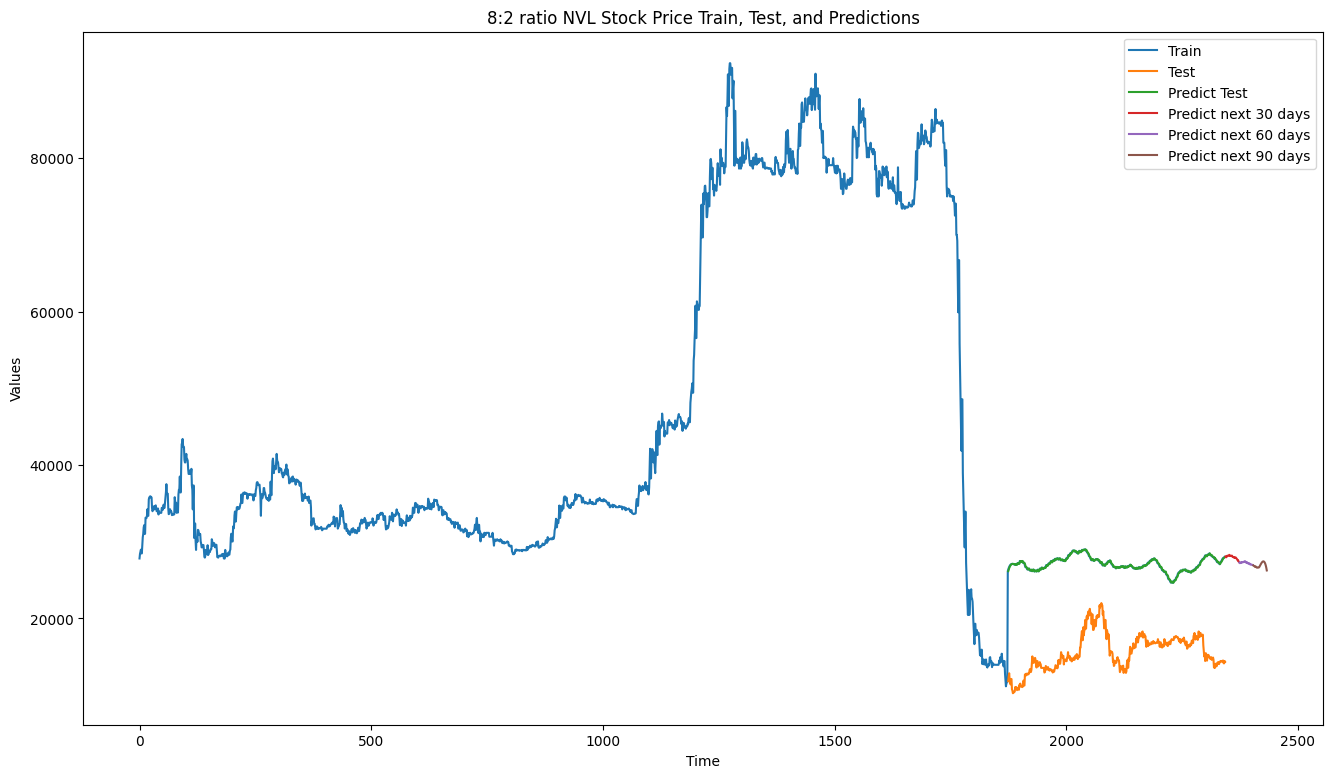

In [ ]:
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)

predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))

predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('8:2 ratio NVL Stock Price Train, Test, and Predictions')
plt.show()